# Applied Deep Learning Tutorial 

contact: Mark.schutera@kit.edu


# Generative Adversarial Neural Networks (GANs)

## Introduction
In this tutorial, you will attempt to implement a Generative Adversarial Neural Network for image generation on the MNIST dataset. Labeled training data is the fuel for supervised machine learning approaches. Thus GANs can be seen as the holy grail when it comes to generating additional data affiliated with a given source domain. GANs have first been introduced by [Goodfellow et al.](http://arxiv.org/abs/1406.2661)

<img src="graphics/stormtrooper.jpg" width="700"><br>
<center> Fig. 1: Stormtrooper reflects the idea of generating multiple instances of the same source domain. </center>


## Introduction 

GANs are based on a joint training of at least two separate neural networks. The generator and the discriminator.
The generator takes an input, most often a latent random input, and maps this input to an output with the dimensions of a source domain sample, meaning real-world data. The discriminator takes inputs from either the source domain or the generator. The discriminator then does a binary classification, learning to distinguish between generated and real samples.

<img src="graphics/GANarchitecture.jpg" width="700"><br>
<center> Fig. 2: Overview of a simple GAN architecture with discriminator and generator. </center>

The training process happens in two passes. During the first pass the generator is frozen, and the discriminator is trained to distinguish between real and generated samples. 
In the second pass, the discriminator is frozen and the generator is trained using the discriminator classification as objective, backpropagating the error. 
By iteratively repeating those two passes, the quality of the generated samples increases, while the ability of the discriminator of distinguishing between real and generated improves too.


# Build your GAN

Do the necessary imports.
And load the [MNIST](http://yann.lecun.com/exdb/mnist/) data set - the hello world for machine learning.


In [13]:
import tensorflow as tf

import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time
import cv2

from IPython import display

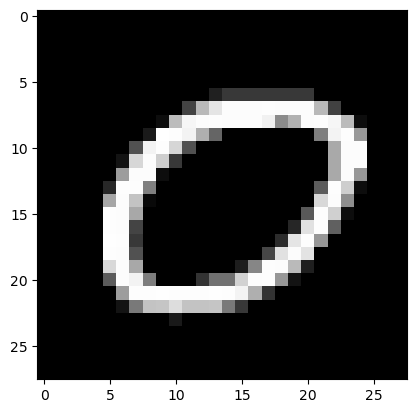

In [10]:
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()

plt.imshow(train_images[156], cmap='gray')

train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5  # Normalize the images to [-1, 1]

BUFFER_SIZE = 60000
BATCH_SIZE = 169

# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

TypeError: 'module' object is not callable

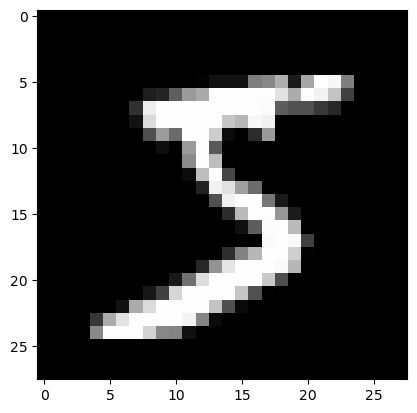

In [44]:
from math import log10, floor
import tqdm

img = train_images[0]
plt.imshow(img, cmap='gray')

dct = cv2.dct(img)
# print(dct[0])

def round_to_1(x):
    return round(x, -int(floor(log10(abs(x)))))

l = []
for ti in train_images:
    for d in cv2.dct(ti):
        for n in d:
            # print(abs(n))
            # print(log10(abs(n)))
            # print(floor(log10(abs(n))))
            # print(-int(floor(log10(abs(n)))))
            # print(round_to_1(n))
            # print(int(round_to_1(n)))
            # print("---")
            l.append(int(abs(n * (10 ** -int(floor(log10(abs(n))))))))
print(len(l))
l = np.array(l)
count = []
for i in range(1,10):
    count.append(np.count_nonzero(l == i))
print(count)



## Designing the Generator

The Generator will be designed as a Fully Connected Neural Network (FCN). Starting from our input x fill in the missing shapes in the `` layers.Conv2DTranspose `` layers. 

In [3]:
##########################################################
#           In this box some code must be added          #
##########################################################

def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256)  # Note: None is the batch size

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)

    return model

2022-10-22 22:02:52.761876: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8500


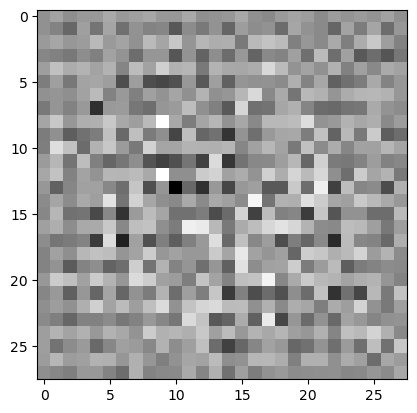

In [4]:
generator = make_generator_model()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

## Designing the Discriminator

The discriminator is a simple CNN, to reduce the information from the input to the decision if the input is real or fake. 

###### Why is the discriminator architecture so similar to the generator? Discuss complexity of the two models with respect to their task.

In [5]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

In [6]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print(decision)

tf.Tensor([[0.00242241]], shape=(1, 1), dtype=float32)


## Objective Function - Min Max Game

The loss for the discriminator is as follows:
\begin{align}
    -\log_{10}(discriminator_{real})-\log_{10}(1-discriminator_{fake})
\end{align}

For better understanding lets assume a generated sample. When feeding the generated sample into the discriminator and the discriminator is able to detect the domain, the sigmoid output will be a value around 0. The loss should thus be low in this case. We achieve this by capsuling the discriminator output as: 

$\log_{10}(1-discriminator_{fake})$.

- If the generated image is detected as such, the loss will be $-\log(1-(0))=-\log(1)$ and thus tending to become 0. 
- If the generated image is detected as source image, the loss will be $-\log(1-(1))=-\log(0)$ and thus tending to become inifite large. 

The loss is determined over multiple samples, thus the mean output of the models is considered

To speed up the code, the ``tf.keras.losses.BinaryCrossentropy`` loss function was used. This loss also relies on logarithmic functions. 

##### Elaborate the loss for a real image given to the discriminator

##### Elaborate the loss for the generator 

In [7]:
# This method returns a helper function to compute cross entropy loss
# from_logits=True means, that the output of the model is not clipped between 0 and 1 and could potentially be infinit
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

#### Discriminator loss

In [8]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    
    return total_loss

#### Generator Loss

In [9]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

## Setting up the Training and Optimizer

Set up the optimizer as Adam optimizer.

In [10]:
# generator_optimizer = tf.keras.optimizers.Adam(1e-4)
# discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

learning_rate = 0.0002

generator_optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)


checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [11]:
##########################################################
#           In this box some code must be added          #
##########################################################

# Experiment with the number of epochs

EPOCHS = 150 
noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])

# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [12]:
def train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()

        for image_batch in dataset:
            train_step(image_batch)

        # Produce images for the GIF as you go
        display.clear_output(wait=True)
        generate_and_save_images(generator,
                                 epoch + 1,
                                 seed)

        # Save the model every 15 epochs
        if (epoch + 1) % 15 == 0:
            checkpoint.save(file_prefix = checkpoint_prefix)

        # Generate after the final epoch
        display.clear_output(wait=True)
        generate_and_save_images(generator,
                               epochs,
                               seed)

        print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

In [13]:
def generate_and_save_images(model, epoch, test_input):
    predictions = model(test_input, training=False)

    fig = plt.figure(figsize=(4, 4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')

    # plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

## Start the Training

The error message in the following console output is caused by manually interrupting the process.

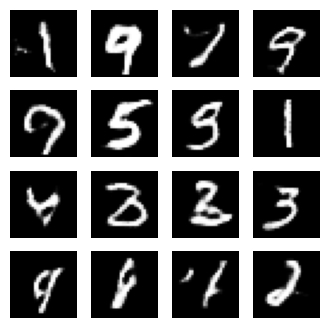

Time for epoch 150 is 9.184671401977539 sec


In [14]:
train(train_dataset, EPOCHS)
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

##### Why do we only load the MNIST images and not the groundtruth? 
The GAN does not care for class labels, and the domain labels are already given by the pipeline.

## Taking the Generator for a ride.

After training the generator, we do a visual check of the generated samples.

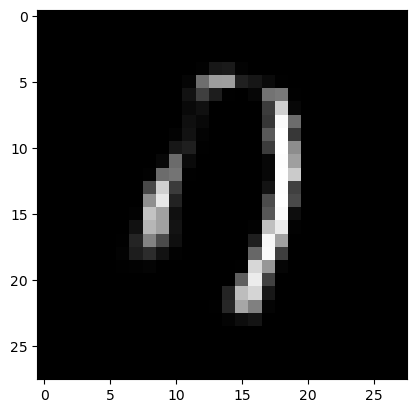

In [20]:
# Testing
# Generate images from a latent random variable, using the generator network.
# first we will create an empty np.array with the size of 28x28 
canvas = np.empty((28, 28))

# We will generate the latent random variable drawing from the uniform distribution in [-1, 1] as a 1x100 tensor
z = np.random.uniform(-1., 1., size=[1, noise_dim])

# we will now feed z as input to the generator
g = generator(z, training=False)

plt.imshow(g[0, :, :, 0], cmap='gray')
plt.show()

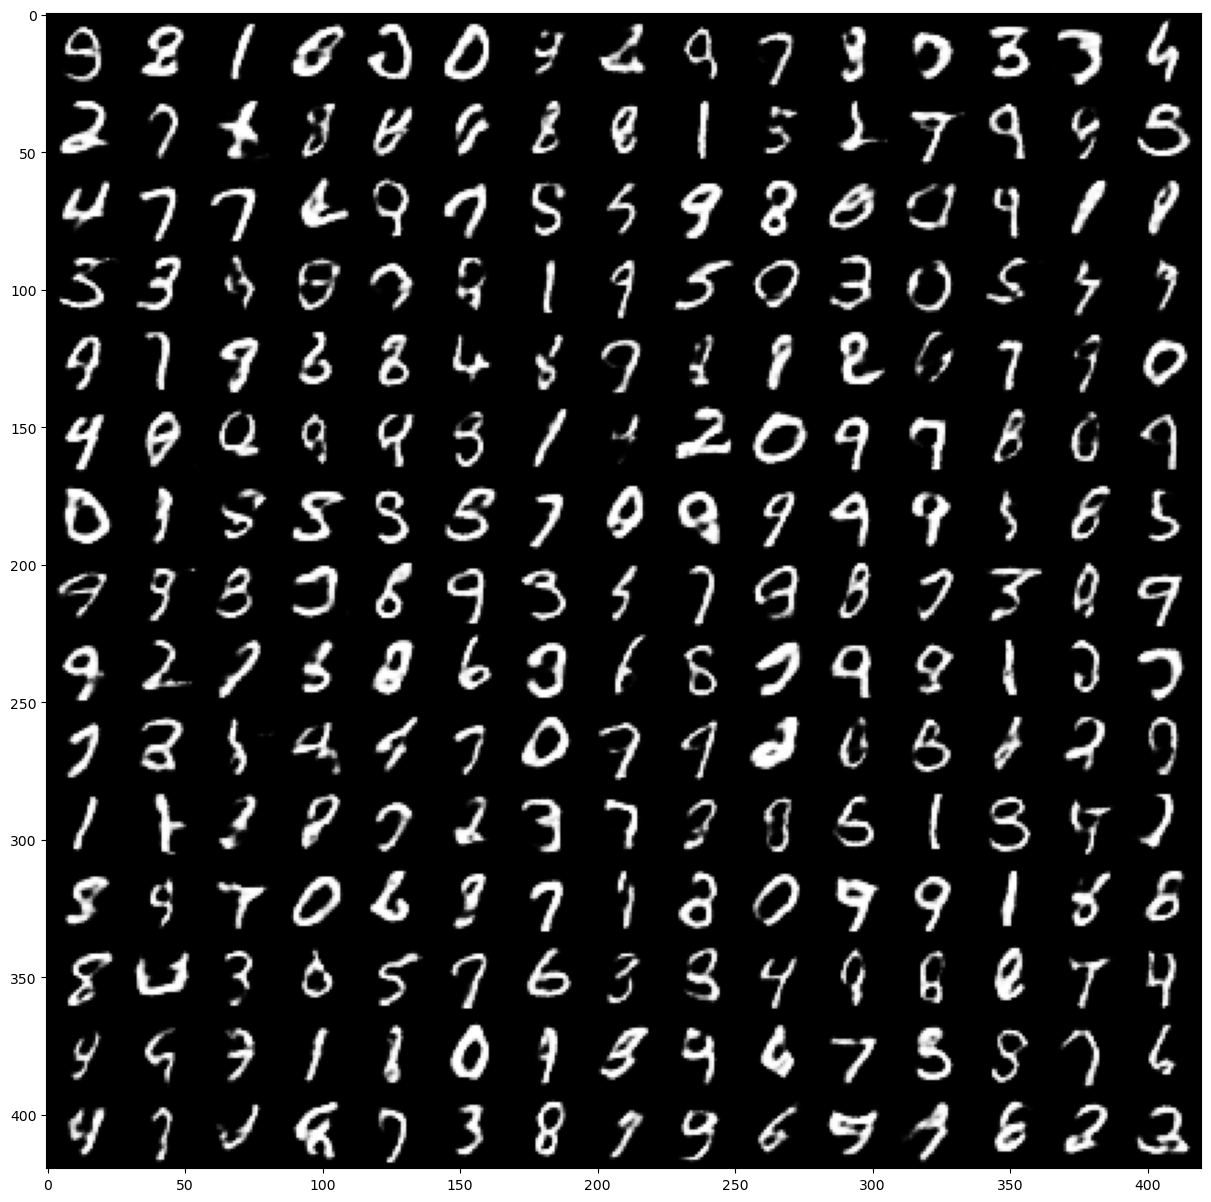

In [21]:
# Generate n*n images from noise, using the generator network.
n = 15
canvas = np.empty((28 * n, 28 * n))
for i in range(n):
    z = np.random.uniform(-1., 1., size=[n, noise_dim])
    # Generate image from noise.
    # g = sess.run(generator(gen_input), feed_dict={gen_input: z})
    g = generator(z, training=False)

    for j in range(n):
        # Draw the generated digits
        canvas[i * 28:(i + 1) * 28, j * 28:(j + 1) * 28] = g[j].numpy().reshape([28, 28])

plt.figure(figsize=(n, n))
plt.imshow(canvas, origin="upper", cmap="gray")
plt.show()

## Next steps to take it from here

- We can notice that some digits are generated more frequent than others, why is that. Implement an approach that does solve this issue or at least weaken the effect.
- So far we have only evaluated the performance of the generator qualitatively. How could a quantitative evaluation look like? Implement a quantitative evaluation.
